# Calculate Disperser transmission for simulation

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

## Setup

### import

In [82]:
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [83]:
import seaborn as sns

In [84]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [85]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [86]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [87]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../merra2'

In [88]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [89]:
from spectractorsim import *
from libspecana import *

thrpt_SimClearSky.csv
thrpt_AverClearSky.csv	
thrpt_Merra2Sky.csv	

thrpt_Ron400.csv
thrpt_Thor300.csv
thrpt_HoloPhP.csv	
thrpt_HoloPhAg.csv	
thrpt_HoloAmAg.csv	

In [90]:
all_files_08jun17=["thrpt_Ron200.csv","thrpt_Thor300.csv","thrpt_HoloPhP.csv","thrpt_HoloPhAg.csv","thrpt_HoloAmAg.csv",
           "thrpt_SimClearSky.csv","thrpt_SimAverSky.csv","thrpt_SimMerra2Sky.csv"]

In [91]:
topdir="data"

In [92]:
subdir="08jun17/HD111980"

In [93]:
path=os.path.join(topdir,subdir)

In [94]:
def GetLogDisperserTransm(thefile):
    df=pd.read_csv(thefile)
    
    X=df["wl"].values
    Y=df["thrpt"].values
    good_indexes=np.where(Y!=0)[0]
    X=X[good_indexes]
    Y=Y[good_indexes]
    return X,Y

In [95]:
def GetLogDisperserTransmwthErr(thefile):
    df=pd.read_csv(thefile)
    
    X=df["wl"].values
    Y=df["thrpt"].values
    EY=df["err"].values
    good_indexes=np.where(Y!=0)[0]
    X=X[good_indexes]
    Y=Y[good_indexes]
    EY=EY[good_indexes]
    return X,Y,EY

In [96]:
def Extrapolate(X,Y):
    # extrapolate X and Y
    YMIN=Y.min()-1.
    X=np.insert(X,0,X[0]-1)
    X=np.insert(X,0,WL[0])
    X=np.append(X,WL[-1])
 
    Y=np.insert(Y,0,YMIN)
    Y=np.insert(Y,0,YMIN)
    Y=np.append(Y,YMIN)
    return X,Y

In [97]:
def ExtrapolatewthErr(X,Y,EY):
    # extrapolate X and Y
    YMIN=Y.min()-1.
    EYMAX=EY.max()
    
    X=np.insert(X,0,X[0]-1)
    X=np.insert(X,0,WL[0])
    X=np.append(X,WL[-1])
 
    Y=np.insert(Y,0,YMIN)
    Y=np.insert(Y,0,YMIN)
    Y=np.append(Y,YMIN)
    
    EY=np.insert(EY,0,EYMAX)
    EY=np.insert(EY,0,EYMAX)
    EY=np.append(EY,EYMAX)
    
    return X,Y,EY

In [98]:
def GetLinearDisperserTrans(X,Y):
    X,Y=Extrapolate(X,Y)
    indexes=np.argsort(X)
    X=X[indexes]
    Y=Y[indexes]
    Y=smooth(Y,window_len=11)
    
    if(len(Y)>len(X)):
        Y=np.delete(Y, -1)
    elif(len(X)>len(Y)):
        X=np.delete(X, -1)
        
    
    #print len(X),len(Y)
    func = interpolate.interp1d(X, Y)   
    newY=np.power(10.,func(WL)/2.5)
    return WL,newY

In [99]:
def GetLinearDisperserTranswthErr(X,Y,EY):
    X,Y,EY=ExtrapolatewthErr(X,Y,EY)
    indexes=np.argsort(X)
    X=X[indexes]
    Y=Y[indexes]
    EY=EY[indexes]
    
    Y1=Y-EY
    Y2=Y+EY
    
    
    Y=smooth(Y,window_len=11)
    Y1=smooth(Y1,window_len=11)
    Y2=smooth(Y2,window_len=11)
   
    
    if(len(Y)>len(X)):
        Y=np.delete(Y, -1)
    elif(len(X)>len(Y)):
        X=np.delete(X, -1)
        
    if(len(Y1)>len(X)):
        Y1=np.delete(Y1, -1)
    if(len(Y2)>len(X)):
        Y2=np.delete(Y2, -1)
    
    #print len(X),len(Y),len(Y1),len(Y2)
    
  
    
    func = interpolate.interp1d(X, Y)   
    func1 = interpolate.interp1d(X, Y1) 
    func2 = interpolate.interp1d(X, Y2) 
    
    newY=np.power(10.,func(WL)/2.5)   
    newY1=np.power(10.,func1(WL)/2.5)
    newY2=np.power(10.,func2(WL)/2.5)
    
    
    return WL,newY,newY1,newY2

In [100]:
def plotMagnitude(X,Y,EY,thetitle):
    plt.plot(X,Y,'bo-')
    plt.fill_between(X,y1=Y-EY,y2=Y+EY,facecolor='grey',alpha=0.5)
    plt.grid()
    plt.legend()
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("throughput (mag)")
    plt.title(thetitle)

In [101]:
def plotLinTransmission(X,Y,Y1,Y2,thetitle):
    plt.plot(X,Y,'b-')
    plt.errorbar(X,Y,yerr=np.abs(Y1-Y2)/2.,marker='.',color='blue',ecolor='red')
    plt.fill_between(X,y1=Y1,y2=Y2,facecolor='grey',alpha=0.5)
    plt.grid()
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("relative throughput")
    plt.title(thetitle)

# Simulation

In [102]:
tel=TelescopeTransmission()
trans=tel.load_transmission()

In [103]:
tr=trans(WL)

In [104]:
thefilename1=os.path.join(path,all_files_08jun17[5])
X1s,Y1s=GetLogDisperserTransm(thefilename1)

In [105]:
X0=X1s
Y0=Y1s

In [106]:
newX0,newY0=GetLinearDisperserTrans(X0,Y0)

In [107]:
thefilename2=os.path.join(path,all_files_08jun17[6])
X2s,Y2s=GetLogDisperserTransm(thefilename2)

In [108]:
thefilename3=os.path.join(path,all_files_08jun17[7])
X3s,Y3s=GetLogDisperserTransm(thefilename3)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5,1,'Optical Throughput in simulation')

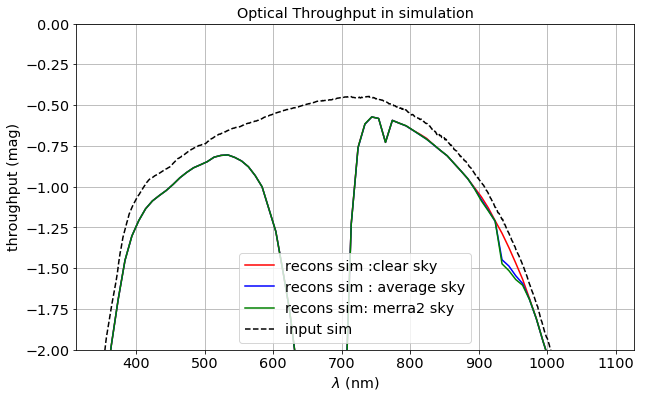

In [109]:
plt.plot(X1s,Y1s,'r-',label='recons sim :clear sky')
plt.plot(X2s,Y2s,'b-',label='recons sim : average sky')
plt.plot(X3s,Y3s,'g-',label='recons sim: merra2 sky')
plt.plot(WL,2.5*np.log10(tr),'k--',label='input sim')
plt.grid(True)
plt.ylim(-2.,0.)
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title("Optical Throughput in simulation")

Text(0.5,1,'Optical Throughput in simulation')

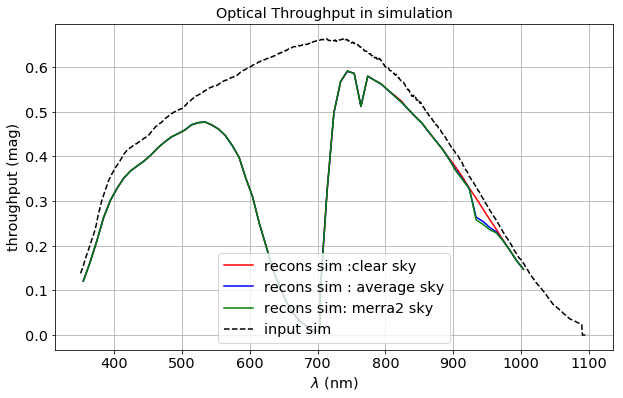

In [110]:
plt.plot(X1s,np.power(10.,Y1s/2.5),'r-',label='recons sim :clear sky')
plt.plot(X2s,np.power(10.,Y2s/2.5),'b-',label='recons sim : average sky')
plt.plot(X3s,np.power(10.,Y3s/2.5),'g-',label='recons sim: merra2 sky')
plt.plot(WL,tr,'k--',label='input sim')
plt.grid(True)
#plt.ylim(-2.,0.)
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title("Optical Throughput in simulation")

# Ronchi200

In [111]:
thefilename=os.path.join(path,all_files_08jun17[0])

In [112]:
ls $path

thrpt_HoloAmAg.csv      thrpt_Ron200.csv        thrpt_SimMerra2Sky.csv
thrpt_HoloPhAg.csv      thrpt_SimAverSky.csv    thrpt_Thor300.csv
thrpt_HoloPhP.csv       thrpt_SimClearSky.csv


In [113]:
X1,Y1,EY1=GetLogDisperserTransmwthErr(thefilename)

In [114]:
thetitle="Optical Throughput for Ronchi200"

2018-05-18 22:11:59  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


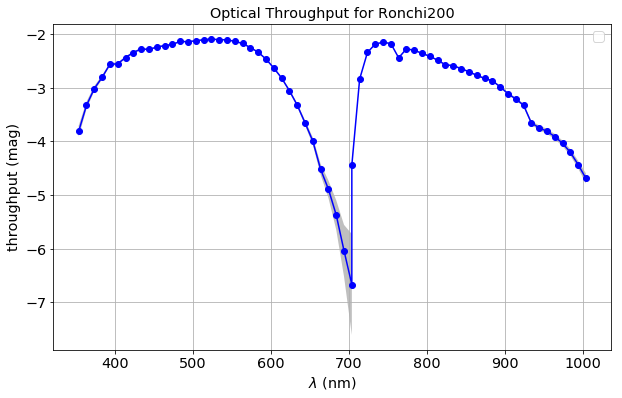

In [115]:
plotMagnitude(X1,Y1,EY1,thetitle)

In [116]:
newX1,newY1,newY1err,newY2err=GetLinearDisperserTranswthErr(X1,Y1,EY1)
newErr1=(newY2err-newY1err)/2.

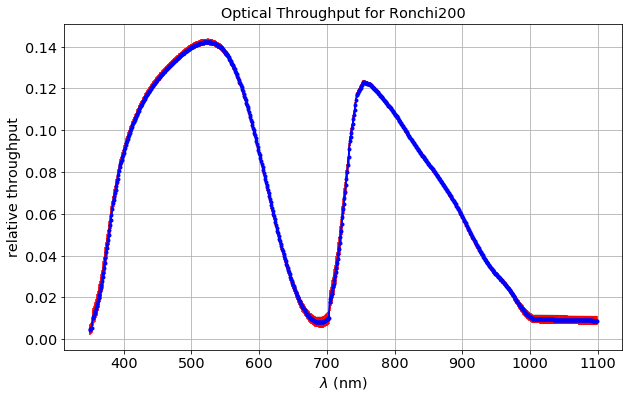

In [117]:
plotLinTransmission(newX1,newY1,newY1err,newY2err,thetitle)

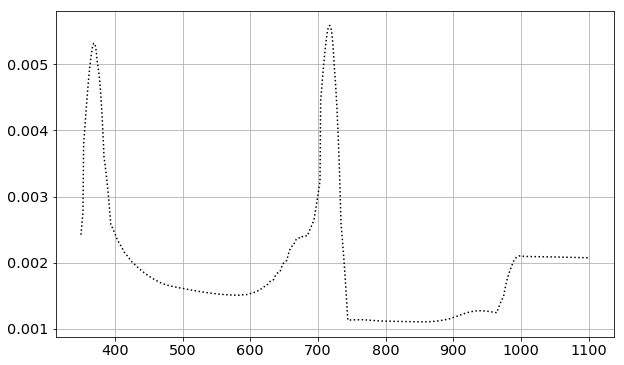

In [118]:
plt.plot(newX1,newErr1,'k:')
plt.grid()

# ThorLab

In [119]:
thefilename=os.path.join(path,all_files_08jun17[1])

In [120]:
X2,Y2,EY2=GetLogDisperserTransmwthErr(thefilename)

In [121]:
thetitle="Optical Throughput for Thor300"

2018-05-18 22:12:00  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


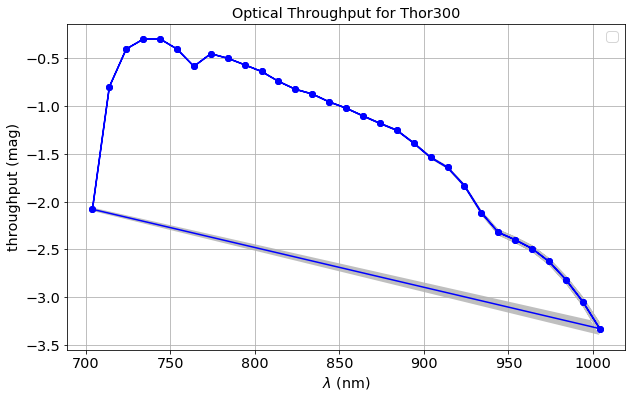

In [122]:
plotMagnitude(X2,Y2,EY2,thetitle)

In [123]:
newX2,newY2,newY1err,newY2err=GetLinearDisperserTranswthErr(X2,Y2,EY2)
newErr2=(newY2err-newY1err)/2.

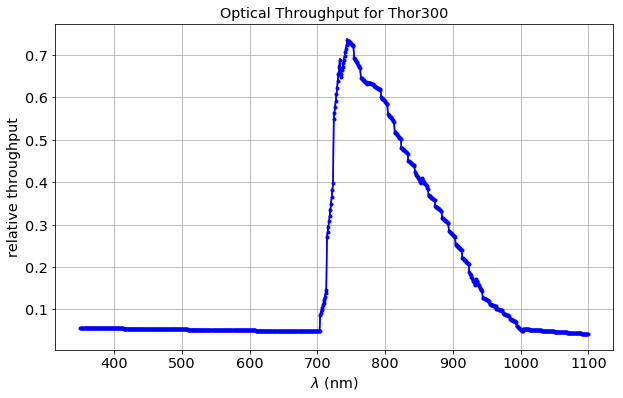

In [124]:
plotLinTransmission(newX2,newY2,newY1err,newY2err,thetitle)

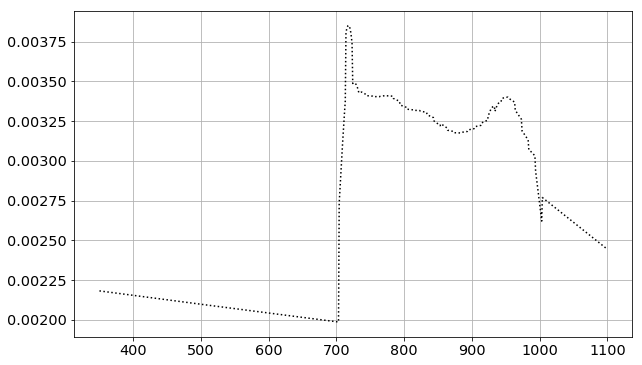

In [125]:
plt.plot(newX2,newErr2,'k:')
plt.grid()

# HoloPhP

In [126]:
thefilename=os.path.join(path,all_files_08jun17[2])

In [127]:
X3,Y3,EY3=GetLogDisperserTransmwthErr(thefilename)

In [128]:
thetitle="Optical Throughput for HoloPhP"

2018-05-18 22:12:01  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


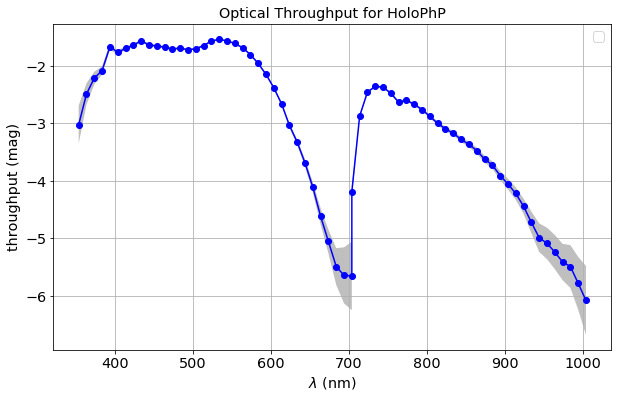

In [129]:
plotMagnitude(X3,Y3,EY3,thetitle)

In [130]:
newX3,newY3,newY1err,newY2err=GetLinearDisperserTranswthErr(X3,Y3,EY3)
newErr3=(newY2err-newY1err)/2.

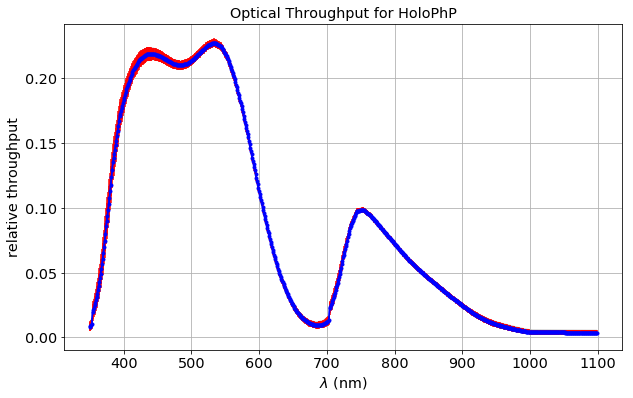

In [131]:
plotLinTransmission(newX3,newY3,newY1err,newY2err,thetitle)

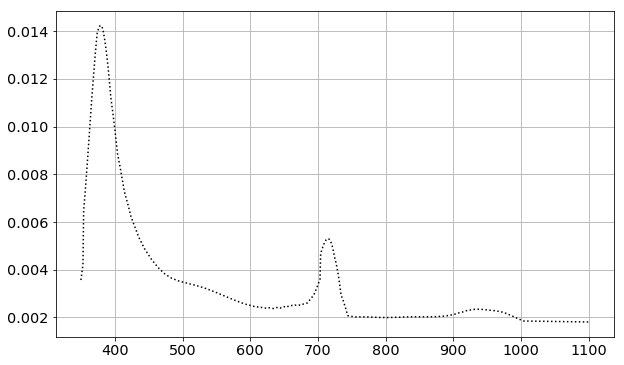

In [132]:
plt.plot(newX3,newErr3,'k:')
plt.grid()

# HoloPhAg

In [133]:
thefilename=os.path.join(path,all_files_08jun17[3])

In [134]:
X4,Y4,EY4=GetLogDisperserTransmwthErr(thefilename)

In [135]:
thetitle="Optical Throughput for HoloPhAg"

2018-05-18 22:12:02  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


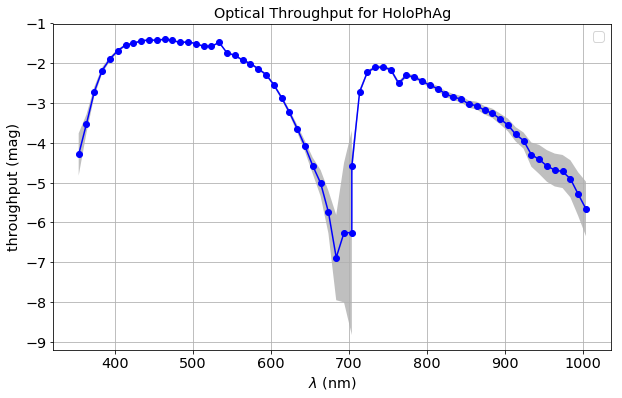

In [136]:
plotMagnitude(X4,Y4,EY4,thetitle)

In [137]:
newX4,newY4,newY1err,newY2err=GetLinearDisperserTranswthErr(X4,Y4,EY4)
newErr4=(newY2err-newY1err)/2.

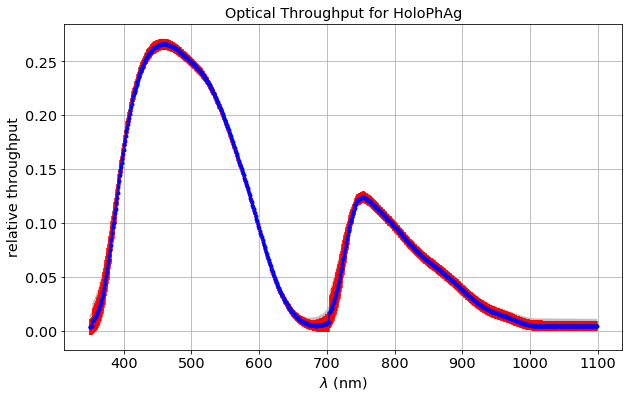

In [138]:
plotLinTransmission(newX4,newY4,newY1err,newY2err,thetitle)

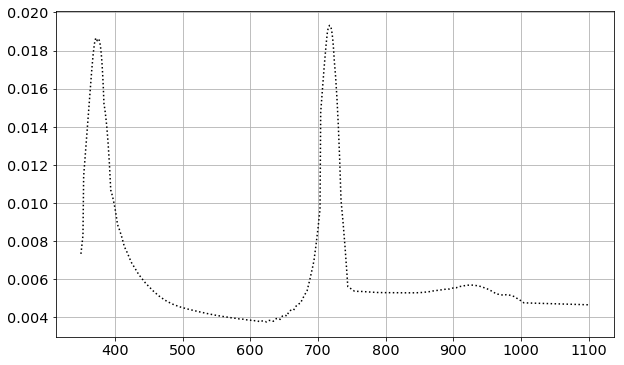

In [139]:
plt.plot(newX4,newErr4,'k:')
plt.grid()

# HoloAmAg

In [140]:
thefilename=os.path.join(path,all_files_08jun17[4])

In [141]:
X5,Y5,EY5=GetLogDisperserTransmwthErr(thefilename)

In [142]:
thetitle="Optical Throughput for HoloAmAg"

2018-05-18 22:12:03  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


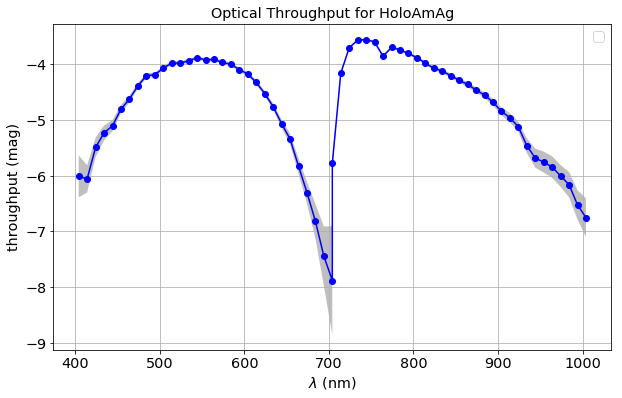

In [143]:
plotMagnitude(X5,Y5,EY5,thetitle)

In [144]:
newX5,newY5,newY1err,newY2err=GetLinearDisperserTranswthErr(X5,Y5,EY5)
newErr5=(newY2err-newY1err)/2.

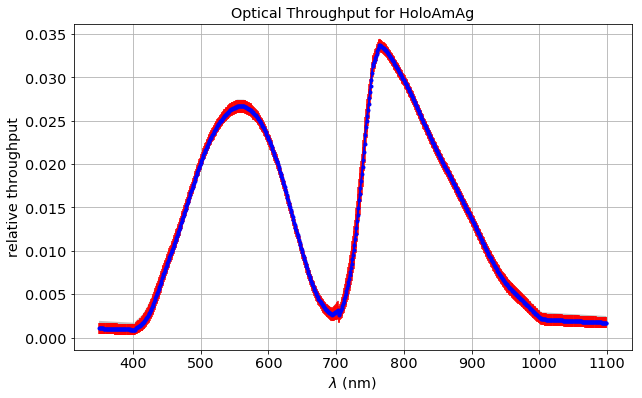

In [145]:
plotLinTransmission(newX5,newY5,newY1err,newY2err,thetitle)

In [146]:
newX5,newY5=GetLinearDisperserTrans(X5,Y5)

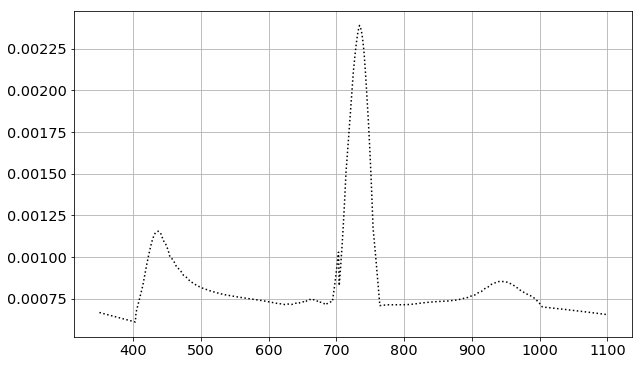

In [147]:
plt.plot(newX5,newErr5,'k:')
plt.grid()

# Data Frame

In [148]:
df=pd.DataFrame()

In [149]:
df["wl"]=WL
df["thrpt_ron200"]=newY1
df["thrpt_thor300"]=newY2
df["thrpt_holoPhP"]=newY3
df["thrpt_holoPhAg"]=newY4
df["thrpt_holoAmAg"]=newY5

In [150]:
df.head()

,wl,thrpt_ron200,thrpt_thor300,thrpt_holoPhP,thrpt_holoPhAg,thrpt_holoAmAg
0,350,0.004438,0.056587,0.008298,0.003488,0.001060
1,351,0.004780,0.056561,0.008966,0.003798,0.001057
2,352,0.005149,0.056535,0.009688,0.004135,0.001054
3,353,0.005546,0.056509,0.010468,0.004503,0.001051
4,354,0.010022,0.056483,0.019414,0.008917,0.001047


In [151]:
df.to_csv("disp_thrpt_080617_hd111980.csv")

# Disperser comparison

Text(0.5,1,'Comparison of optical throughput (08/06/17)')

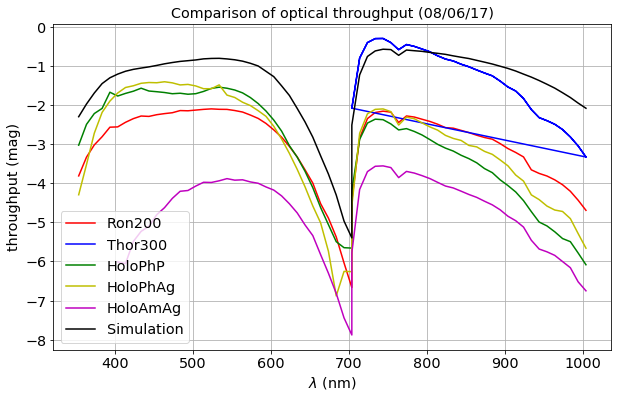

In [152]:
thetitle="Comparison of optical throughput (08/06/17)"
plt.plot(X1,Y1,'r-',label='Ron200')
plt.plot(X2,Y2,'b-',label='Thor300')
plt.plot(X3,Y3,'g-',label='HoloPhP')
plt.plot(X4,Y4,'y-',label='HoloPhAg')
plt.plot(X5,Y5,'m-',label='HoloAmAg')
plt.plot(X0,Y0,'k-',label='Simulation')
plt.legend(loc='upper right')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title(thetitle)

Text(0.5,1,'Comparison of optical throughput (08/06/17)')

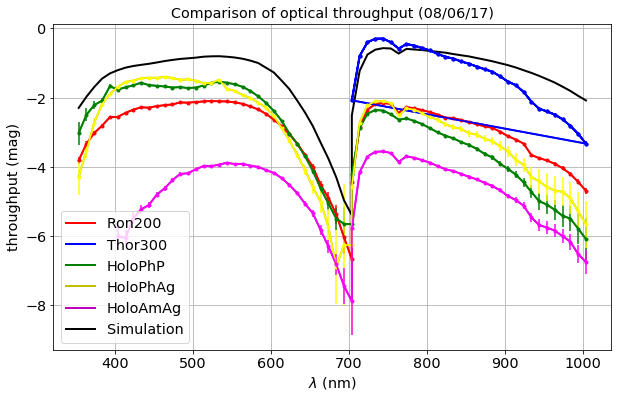

In [153]:
thetitle="Comparison of optical throughput (08/06/17)"
plt.plot(X1,Y1,'r-',label='Ron200',lw=2)
plt.errorbar(X1,Y1,yerr=EY1 ,marker='.',color='red',ecolor='red')
plt.plot(X2,Y2,'b-',label='Thor300',lw=2)
plt.errorbar(X2,Y2,yerr=EY2 ,marker='.',color='blue',ecolor='blue')
plt.plot(X3,Y3,'g-',label='HoloPhP',lw=2)
plt.errorbar(X3,Y3,yerr=EY3 ,marker='.',color='green',ecolor='green')
plt.plot(X4,Y4,'y-',label='HoloPhAg',lw=2)
plt.errorbar(X4,Y4,yerr=EY4 ,marker='.',color='yellow',ecolor='yellow')
plt.plot(X5,Y5,'m-',label='HoloAmAg',lw=2)
plt.errorbar(X5,Y5,yerr=EY5 ,marker='.',color='magenta',ecolor='magenta')
plt.plot(X0,Y0,'k-',label='Simulation',lw=2)
plt.legend(loc='lower left')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title(thetitle)

Text(0.5,1,'Comparison of optical throughput (08/06/17)')

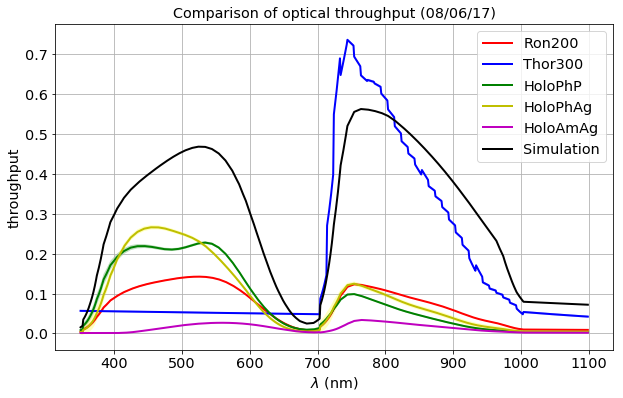

In [154]:
thetitle="Comparison of optical throughput (08/06/17)"
plt.plot(newX1,newY1,'r-',label='Ron200',lw=2)
plt.fill_between(newX1,y1=newY1-newErr1,y2=newY1+newErr1,facecolor='red',alpha=0.25)   
plt.plot(newX2,newY2,'b-',label='Thor300',lw=2)
plt.fill_between(newX2,y1=newY2-newErr2,y2=newY2+newErr2,facecolor='blue',alpha=0.25)   
plt.plot(newX3,newY3,'g-',label='HoloPhP',lw=2)
plt.fill_between(newX3,y1=newY3-newErr3,y2=newY3+newErr3,facecolor='green',alpha=0.25)   
plt.plot(newX4,newY4,'y-',label='HoloPhAg',lw=2)
plt.fill_between(newX4,y1=newY4-newErr4,y2=newY4+newErr4,facecolor='yellow',alpha=0.25) 
plt.plot(newX5,newY5,'m-',label='HoloAmAg',lw=2)
plt.fill_between(newX5,y1=newY5-newErr5,y2=newY5+newErr5,facecolor='magenta',alpha=0.25) 
plt.plot(newX0,newY0,'k-',label='Simulation',lw=2)
plt.legend(loc='upper right')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput")
plt.title(thetitle)

In [155]:
output_file='ctio_throughput_080617_v0.txt'
output_file_thor='ctio_ratioThorRon_080617_v0.txt'
output_file_php='ctio_ratioPhPRon_080617_v0.txt'
output_file_phag='ctio_ratioPhPRon_080617_v0.txt'
output_file_phag='ctio_ratioPhAgRon_080817_v0.txt'
output_file_amag='ctio_ratioAmAgRon_080617_v0.txt'

In [156]:
np.savetxt(output_file,np.c_[WL,newY1,newErr1])

In [157]:
R1=newY2/newY1
ER1=R1*np.sqrt((newErr1/newY1)**2+(newErr2/newY2)**2)
np.savetxt(output_file_thor,np.c_[WL,R1,ER1])

In [158]:
R2=newY3/newY1
ER2=R2*np.sqrt((newErr1/newY1)**2+(newErr3/newY3)**2)
np.savetxt(output_file_php,np.c_[WL,R2,ER2])

In [159]:
R3=newY4/newY1
ER3=R3*np.sqrt((newErr1/newY1)**2+(newErr4/newY4)**2)
np.savetxt(output_file_phag,np.c_[WL,R3,ER3])

In [160]:
R4=newY5/newY1
ER4=R4*np.sqrt((newErr1/newY1)**2+(newErr5/newY5)**2)
np.savetxt(output_file_amag,np.c_[WL,R4,ER4])

<ErrorbarContainer object of 3 artists>

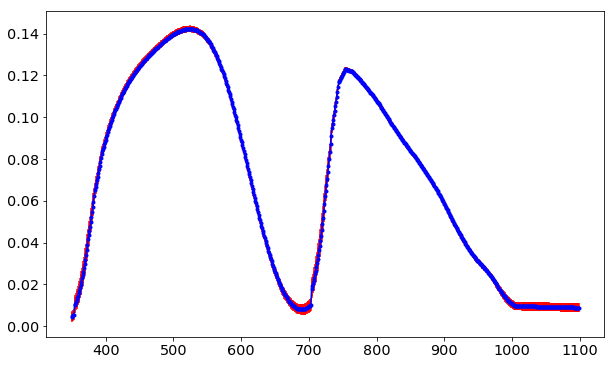

In [161]:
plt.errorbar(WL,newY1,yerr=newErr1,marker='.',color='blue',ecolor='red')

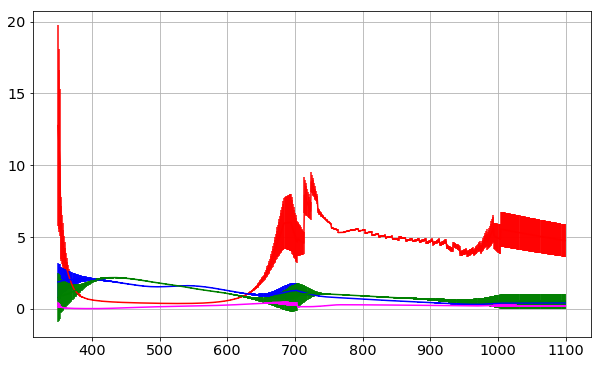

In [162]:
plt.errorbar(WL,R1,yerr=ER1,color='red')
plt.errorbar(WL,R2,yerr=ER2,color='blue')
plt.errorbar(WL,R3,yerr=ER3,color='green')
plt.errorbar(WL,R4,yerr=ER4,color='magenta')
plt.grid()